##### This script will associate spoken phrases with their corresponding translation, using a convolutional neural network ("CNN")

I am going to start by using subset of a few phrases I chose manually from Female 1. (index_TORGO_test.txt)

In [8]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [38]:
# Load index of test data

# *** Load prompt_id as text with leading zeros
# *** Make sure when implemented on larger dataset, to ignore where prompt is None and where has_spect is No

df = pd.read_csv('index_TORGO_test.txt', sep=",", converters={'prompt_id': lambda x: str(x)})
df.head(20)

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt
0,F01,Session1,wav_headMic,0014,yes,206,513,he slowly takes a short walk in the open air e...
1,F01,Session1,wav_headMic,0015,yes,67,513,air
2,F01,Session1,wav_headMic,0018,yes,65,513,no
3,F01,Session1,wav_headMic,0020,yes,153,513,Usually minus several buttons.
4,F01,Session1,wav_headMic,0024,yes,53,513,knee
5,F01,Session1,wav_headMic,0025,yes,73,513,feet
6,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.
7,F01,Session1,wav_headMic,0032,yes,237,513,She had your dark suit in greasy wash water al...
8,F01,Session1,wav_headMic,0046,yes,44,513,chair
9,F01,Session1,wav_headMic,0075,yes,43,513,warm


### 1) Pad Images

This model will rely on the spectrogram images we generated from each audio file. I believe the CNN requires these images to be the same size. They are currenly all the same height (frequency axis), but are not the same width (time axis). Therefore, I will pad the end of each image so that all of the images are also the same width - using the max width of all the images.

[Tutorial for Padding with OpenCV](https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html)

In [23]:
# Get max width, which all images will be padded up to.
maxwidth = df['spect_width'].max()
print(maxwidth)

237


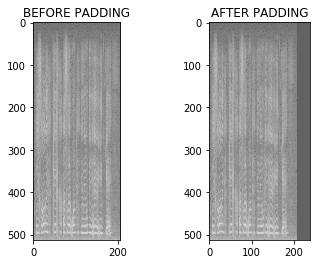

In [37]:
# View example of before and after padding
img_loc = '/'.join(['../data/TORGO', df['speaker'][0], df['session'][0], df['mic'][0]+'_spect', df['prompt_id'][0]+'.png'])

# Image before padding
img = cv2.imread(img_loc)
imgplot = plt.subplot(121),plt.imshow(img),plt.title('BEFORE PADDING')

# Image after padding
pad = maxwidth - img.shape[1]
img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=[98,98,98])
imgplot_new = plt.subplot(122),plt.imshow(img_new),plt.title('AFTER PADDING')

In [39]:
# Get all predictor variables (padded images) and outcome variable (prompt)
x = []
y = []

for index, row in df.iterrows(): 
    img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'.png'])
    img = cv2.imread(img_loc)
    pad = maxwidth - img.shape[1]
    img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=[98,98,98])
    x.append(img_new)
    y.append(row['prompt'])  

In [44]:
# View first 10 records, and verify images are all the same size now
print(y[0:10])

for i in x[0:10]:
    print(i.shape)

['he slowly takes a short walk in the open air each day.', 'air', 'no', 'Usually minus several buttons.', 'knee', 'feet', 'The quick brown fox jumps over the lazy dog.', 'She had your dark suit in greasy wash water all year.', 'chair', 'warm']
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)
(513, 237, 3)


### 2) Set up CNN

Going to attempt to replicate [This Project](https://mabelvj.github.io/capstone_mabelvj/)